# Import des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras import layers
import tensorflow as tf
import keras 
from scipy.stats import norm

2022-04-15 11:19:05.578188: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-15 11:19:05.578212: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
# import du dataset
from tensorflow.keras.datasets import mnist

In [3]:
# Chargement des données en utilisant la méthode mnsit.load()
(x_train,y_train),(x_test,y_test)=mnist.load_data()

In [ ]:
# Mise à l'échelle des données d'entraînement et de test
x_train, x_test = x_train.astype('float32')/255., x_test.astype('float32')/255.
x_train, x_test = x_train.reshape(x_train.shape[0], -1), x_test.reshape(x_test.shape[0], -1)
print(x_train.shape, x_test.shape)


In [4]:
# network parameters
batch_size, n_epoch = 32, 30
latent_dim = 2

# Création d'une couche d'échantillonage

In [5]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Construction de l'encodeur

In [6]:
latent_dim = 2

inputs = keras.Input(shape=(28,28,1))

x = layers.Conv2D(32, 3, activation="relu", strides=1, padding="same")(inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)

x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 28, 28, 32)   320         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 14, 14, 64)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 7, 7, 64)     36928       ['conv2d_1[0][0]']               
                                                                                            

2022-04-15 11:19:27.767942: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-15 11:19:27.767977: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-15 11:19:27.768008: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (hprisser): /proc/driver/nvidia/version does not exist
2022-04-15 11:19:27.768285: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Construction du décodeur

In [7]:
latent_inputs= keras.Input(shape=(latent_dim))

x= layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x= layers.Reshape((7, 7, 64))(x)
x= layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x= layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x= layers.Conv2DTranspose(32, 3, activation="relu", strides=1, padding="same")(x)

decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

decoder.summary()



Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 32)       1846

# Construction de la classe VAE pour le calul de la loss_reconstruction et de la KL_loss:
paramètre K1 et K2

In [8]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

# Implémentation de la VAE

In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer='Adam')

In [10]:
# mise à l'échelle avant entraînement
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

x_train = np.reshape(x_train, newshape=(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1))
x_test = np.reshape(x_test, newshape=(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1))


In [11]:
# Entraînement
vae.fit(x_train, epochs=30, batch_size=32,shuffle=True)

Epoch 1/30
1875/1875 [==============================] - 137s 72ms/step - loss: 211.2650 - reconstruction_loss: 180.7133 - kl_loss: 4.5499
Epoch 2/30
1875/1875 [==============================] - 134s 71ms/step - loss: 164.0559 - reconstruction_loss: 155.9875 - kl_loss: 6.0973
Epoch 3/30
1875/1875 [==============================] - 125s 66ms/step - loss: 158.4410 - reconstruction_loss: 151.5006 - kl_loss: 6.3283
Epoch 4/30
1875/1875 [==============================] - 120s 64ms/step - loss: 155.4883 - reconstruction_loss: 148.8984 - kl_loss: 6.4073
Epoch 5/30
1875/1875 [==============================] - 119s 64ms/step - loss: 153.7169 - reconstruction_loss: 147.1818 - kl_loss: 6.4153
Epoch 6/30
1875/1875 [==============================] - 123s 66ms/step - loss: 152.1229 - reconstruction_loss: 145.6561 - kl_loss: 6.3615
Epoch 7/30
1875/1875 [==============================] - 120s 64ms/step - loss: 150.9609 - reconstruction_loss: 144.5635 - kl_loss: 6.3711
Epoch 8/30
1875/1875 [============

In [12]:
metrics=pd.DataFrame(vae.history.history)

<AxesSubplot:>

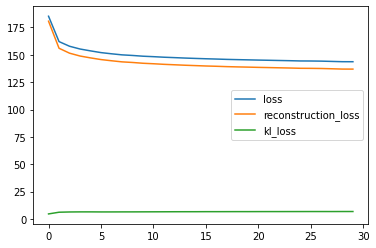

In [13]:
metrics.plot()

In [14]:
# récupération du decoder pour lui fournir un point aléatoire dans l'espace latent pour ressortir une image
# Ce qui donne la capacité de générer des données qui n'existe pas
decoder=vae.get_layer('decoder')

In [36]:
img=decoder(np.array([[0.5,0.9]])

SyntaxError: unexpected EOF while parsing (2426062185.py, line 1)

In [37]:
x=img[0]

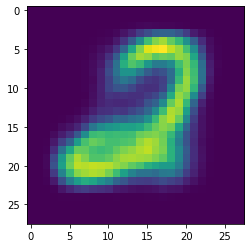

In [38]:
plt.imshow(x)

# Visualisation de l'espace latent

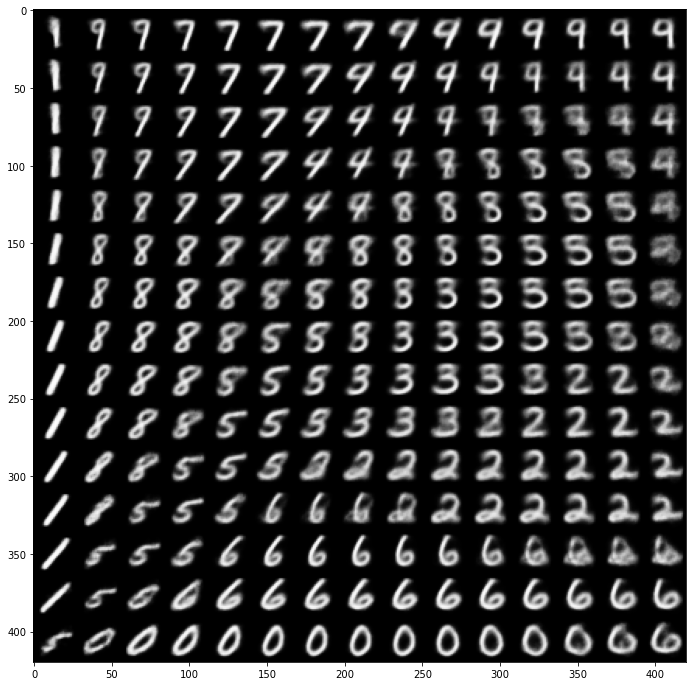

In [18]:
n = 15 # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

grid_x = norm.ppf(np.linspace(0.05, 0.95, n)) 
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure, cmap='Greys_r')
plt.show()

# Représentation des classes de chiffres dans l'espace latent(regroupement des chiffres en cluster càd en fonction de leur similitude/caractéristiques commune)

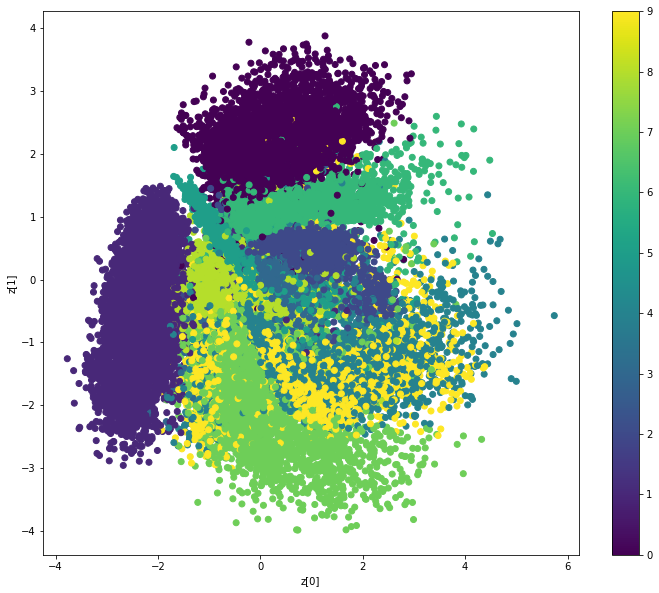

In [19]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)

# Reconsturction de l'image

In [ ]:
z_mean, z_var, z  = vae.encoder.predict(x_test)
x_reconst = vae.decoder.predict(z)

In [ ]:
plt.figure(figsize=(9,3))
toPlot = (x_test, x_reconst)
for i in range(8):
    for j in range(2):
        ax = plt.subplot(3, 10, 10*j+i+1)
        plt.imshow(toPlot[j][i,:].reshape(28,28), interpolation="nearest", 
                   vmin=0, vmax=1)
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

plt.tight_layout()